# Anime LDA Topic Similarity Model

### Read data import

In [1]:
import mysql.connector as my_sql
from dotenv import load_dotenv
import os
import pandas as pd

### Read data

In [2]:
# Load environmental variables
load_dotenv()

True

In [3]:
def query_data():
    """
    Returns a dataframe with an anime's title and synopsis
    """
    
    mydb = my_sql.connect(
        host=os.getenv('DATABASE_HOST'),
        user=os.getenv('DATABASE_USER'),
        password=os.getenv('DATABASE_PASSWORD'),
        database=os.getenv('DATABASE_NAME')
    )
    
    mycursor = mydb.cursor()
    
    mycursor.execute('SELECT Title, Synopsis, MediaType, Genres FROM MAL_Anime_Details')

    df = pd.DataFrame(mycursor.fetchall(), columns=[
        'Title',
        'Synopsis',
        'MediaType',
        'Genres'
    ])
    
    mycursor.close()
    
    return df

In [4]:
df = query_data()

df.head()

,Title,Synopsis,MediaType,Genres
0,Cowboy Bebop,"In the year 2071, humanity has colonized sever...",TV,"Action,Adventure,Comedy,Drama,Sci-Fi,Space"
1,Cowboy Bebop: Tengoku no Tobira,"Another day, another bounty—such is the life o...",Movie,"Action,Drama,Mystery,Sci-Fi,Space"
2,Trigun,"Vash the Stampede is the man with a $$60,000,0...",TV,"Action,Sci-Fi,Adventure,Comedy,Drama,Shounen"
3,Witch Hunter Robin,Witches are individuals with special powers li...,TV,"Action,Mystery,Police,Supernatural,Drama,Magic"
4,Bouken Ou Beet,It is the dark century and the people are suff...,TV,"Adventure,Fantasy,Shounen,Supernatural"


### Clean data imports

In [5]:
import re

### Clean data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14180 entries, 0 to 14179
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      14180 non-null  object
 1   Synopsis   14180 non-null  object
 2   MediaType  14180 non-null  object
 3   Genres     14180 non-null  object
dtypes: object(4)
memory usage: 443.2+ KB


In [7]:
pre_processed_df = df.copy()

In [8]:
pre_processed_df = pre_processed_df[pre_processed_df['MediaType'].isin(['TV', 'Movie', 'OVA', 'Special'])]

In [9]:
pre_processed_df.reset_index(inplace = True, drop = True) 
pre_processed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279 entries, 0 to 12278
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      12279 non-null  object
 1   Synopsis   12279 non-null  object
 2   MediaType  12279 non-null  object
 3   Genres     12279 non-null  object
dtypes: object(4)
memory usage: 383.8+ KB


In [10]:
pre_processed_df = pre_processed_df.drop(['MediaType'], axis=1)

In [11]:
def filter_sources(text):
    """
    Removes the source of the synopsis from the synopsis.
    
    Parameters
    ----------
    text: string
        The synopsis to filter out the source.
    """
    
    new_text = re.sub('\(Source:.*\)', '', text, flags=re.IGNORECASE)
        
    new_text = re.sub('\[(Writt|from|Source).*\]', '', new_text, flags=re.IGNORECASE)
    
    return new_text.strip()

In [12]:
def filter_notes(text):
    """
    Removes the writers note from the synopsis.
    
    Parameters
    ----------
    text: string
        The synopsis to filter out the note.
    """
    
    new_text = re.sub('Note:', '', text, flags=re.IGNORECASE)
    
    
    return new_text.strip()

In [13]:
def filter_japanese_characters(text):
    """
    Removes japanese characters from the synopsis.
    
    Parameters
    ----------
    text: string
        The synopsis to filter out the japanese characters.
    """
    
    new_text = re.sub('/[\u3000-\u303F]|[\u3040-\u309F]|[\u30A0-\u30FF]|[\uFF00-\uFFEF]|[\u4E00-\u9FAF]|[\u2605-\u2606]|[\u2190-\u2195]|\u203B/g', '', text)
        
    return new_text.strip()

In [14]:
def filter_unwanted_text(text):
    """
    Removes unwanted tokens from the text
    
    Parameters
    ----------
    text: string
        The synopsis to filter out unwanted tokens.
    """
    
    no_sources_text = filter_sources(text)
    no_notes_text = filter_notes(no_sources_text)
    no_japanese_text = filter_japanese_characters(no_notes_text)

    return no_japanese_text

In [15]:
pre_processed_df["Synopsis"] = pre_processed_df["Synopsis"].apply(filter_unwanted_text)

In [16]:
pre_processed_df.shape

(12279, 3)

In [17]:
# Dropping rows with no real synopsis
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'No synopsis has been added for this series yet. Click here to update this information.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'No synopsis information has been added to this title. Help improve our database by adding a synopsis here.']
pre_processed_df.reset_index(inplace = True, drop = True) 
pre_processed_df.shape

(11843, 3)

In [18]:
# Dropping rows with non-useful synopsis
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Furukawa Taku film.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Film by Takashi Ito.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A short animation by Taku Furukawa.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A short film by Okamoto Tadanari.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A short puppet animation movie by Tadahito Mochinaga.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short film by Hirano Ryou.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short film by Kurosaka Keita.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Unaired specials included in the Blu-ray and DVD release.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Recap episode.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Movie based on the 1985 TV anime with an original plot.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A mix of animation and live-action.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Film by Tanaami Keiichi.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short animation by Komazaki Tomomi.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short movie from 1931.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short experimental animation from Yoji Kuri.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Short specials added to DVDs and Blu-rays.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Special episodes added to DVDs and Blu-rays.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'Puppet animation by Tadanari Okamoto.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'BD/DVD specials.']
pre_processed_df = pre_processed_df[pre_processed_df['Synopsis'] != 'A special Christmas episode.']
pre_processed_df.reset_index(inplace = True, drop = True) 
pre_processed_df.shape

(11735, 3)

In [19]:
# import collections

# collections.Counter(list(pre_processed_df[pre_processed_df['Synopsis'].duplicated()]['Synopsis'])).most_common()

### Process data imports

In [20]:
from gensim.models import Phrases
import spacy
from spacy.lang.en import English
import string
import unidecode

### Process data

In [21]:
nlp = spacy.load("en_core_web_lg")

In [22]:
spacy_df = pre_processed_df.copy()

In [23]:
def remove_people(text):
    """
    Removes character names from synopsis (identified through Named Entity Recognition).
    
    Parameters
    ----------
    text: string
        The synopsis to filter out the character names.
    """
    
    text_nlp = nlp(text)
    
    for ent in text_nlp.ents:
        if(ent.label_ == 'PERSON'):
            text = text.replace(ent.text, '')
            
    return text

In [24]:
def remove_non_alphabetical_characters(text):
    """
    Cleans text, keeping only alphabetical characters
        
    Parameters
    ----------
    token: str
        Word being processed

    Returns
    -------
    str:
        Cleaned string
    """
    
    text = str(text).translate(str.maketrans(string.punctuation, ' '*len(string.punctuation)))
    
    split_text = [
        ''.join([letter for letter in word if letter.isalpha()])
        for word in text.split()
    ]
    
    cleaned_text = ' '.join(split_text)
    
    return cleaned_text

In [25]:
def prepare_text(text):
    """
    Lemmatizes text using spaCy
        
    Parameters
    ----------
    text: str
        Text being processed

    Returns
    -------
    str:
        Lemmatized text
    """
    
    if text == '':
        return text
    
    # Remove people
    cleaned_text = remove_people(text)
    
    # Clean  
    cleaned_text = remove_non_alphabetical_characters(cleaned_text)
    
    # Tokenize
    tokens = nlp(cleaned_text.lower())
    
    custom_stop_list = [
    'episode',
    'series',
    'short',
    'anime',
    'story',
    'film',
    'feature',
    'character',
    'special',
    'movie',
    'animation',
    'original',
    'release',
    'manga',
    'ova',
    'scene',
    'animate',
    'show',
    'volume',
    'adaptation',
    'video',
    'manga',
    'crossover',
    'season'
    ]
    
    # Lemmatize
    lemmatized_text = ' '.join([token.lemma_ for token in tokens if not token.is_stop and not token.is_punct and (token.pos_ == 'NOUN' or token.pos_ == 'ADJ' or token.pos_ == 'VERB' or token.pos_ == 'ADV') and token.lemma_ not in custom_stop_list])
    
    # Remove short words (<= 2)
    removed_short_words = [x for x in lemmatized_text.split() if len(x) > 2]
    
    full = ' '.join(removed_short_words)
    
    return unidecode.unidecode(full)

In [26]:
def seperate_genres(text):
    """
    Removes punctuation from genres and replaces spaces with underscores. Lastly, returns the genres as a string 
    seperated by a space
    
    Parameters
    ----------
    text: str
        Genres being processed.
    """
    
    split_text = sorted(text.split(','))
    split_text_no_punct = [x.translate(str.maketrans('', '', string.punctuation)) for x in split_text]
    split_text_no_space = [x.replace(' ', '_') for x in split_text_no_punct]
    
    return ' '.join(split_text_no_space).lower()

In [27]:
spacy_df['Genres'] = spacy_df['Genres'].apply(seperate_genres)

In [28]:
spacy_df['Corpus'] = spacy_df['Synopsis']
spacy_df = spacy_df[['Title', 'Corpus', 'Genres']]

spacy_df['Corpus'] = spacy_df['Corpus'].apply(prepare_text)

In [30]:
spacy_df.shape

(11735, 3)

In [31]:
spacy_df = spacy_df[spacy_df['Corpus'].str.split().apply(len) > 0]
spacy_df.reset_index(inplace = True, drop = True) 

In [32]:
spacy_df.shape

(11529, 3)

In [33]:
english_nlp = English()
english_nlp.add_pipe(english_nlp.create_pipe('sentencizer'))
    
def split_doc_to_sentence(doc):
    """
    
    """
    
    split_doc = english_nlp(doc)
    
    return [sent.string.strip() for sent in split_doc.sents]

In [34]:
def create_unigrams(corpus_list):
    """
    
    """

    # Convert document to list of sentences     
    list_of_list = list(map(lambda x: split_doc_to_sentence(x), corpus_list))
    
    flatten = lambda t: [item for sublist in t for item in sublist]
    # Flatten all the sentences in the corpus (multiple sentences in multiple documents => multiple sentences 
    # in 1 document) 
    unigram_sentences = flatten(list_of_list)

    # Split sentences to words     
    unigrams = [x.split() for x in unigram_sentences]

    return unigrams
    
def create_ngrams(grams, stop):
    """
    
    """

    ngram_model = Phrases(grams)

    ngram_sentences = []
    
    for gram in grams:
        ngram_sentence = u' '.join(ngram_model[gram])
        ngram_sentences.append(ngram_sentence)

    if stop:
        return ngram_sentences
    else:
        return [x.split() for x in ngram_sentences]

In [35]:
def add_ngrams_genres_to_documents(df):
    unigram_words = create_unigrams(df['Corpus'].tolist())
    bigram_words = create_ngrams(grams=unigram_words, stop=False)
    trigram_sentences = create_ngrams(grams=bigram_words, stop=True)
    
    df.reset_index(inplace = True, drop = True) 

    for i, synopsis in enumerate(trigram_sentences, start=0):
        df['Corpus'][i] = synopsis + ' ' + df['Genres'][i]

In [36]:
add_ngrams_genres_to_documents(spacy_df)

In [37]:
spacy_df.shape

(11529, 3)

In [38]:
spacy_df = spacy_df[spacy_df['Corpus'].str.split().apply(len) >= 22]
spacy_df.reset_index(inplace = True, drop = True) 

In [39]:
spacy_df.shape

(6560, 3)

In [40]:
# collections.Counter(list(spacy_df[spacy_df['Corpus'].duplicated()]['Corpus'])).most_common()

### Topic Modeling

In [41]:
from collections import defaultdict
from gensim import corpora, models

In [42]:
def create_LDA_tools(documents):
    """
    
    """
    
    texts = [
        [token for token in text.split()]
        for text in documents
    ]

    dictionary = corpora.Dictionary(texts)
    dictionary.filter_extremes(no_below=35, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    return texts, dictionary, corpus

In [43]:
texts, dictionary, corpus = create_LDA_tools(spacy_df['Corpus'])

In [44]:
def get_coherence_scores(dictionary, corpus, texts, start, stop, step):
    """
    
    """
    
    mallet_path = os.getenv('MALLET_PATH')
    coherence_values = []
    model_list = []
    
    for num_topics in range(start, stop, step):
        model = models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, iterations=1000, optimize_interval=10)
        model_list.append(model)
        coherencemodel = models.CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

In [45]:
model_list, coherence_values = get_coherence_scores(dictionary=dictionary, corpus=corpus, texts=texts, start=5, stop=36, step=1)

### Visual analysis imports

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

### Visual analysis

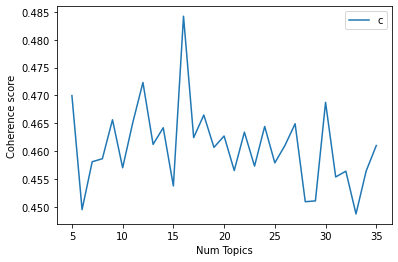

In [47]:
start=5; stop=36; step=1;
x = range(start, stop, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [48]:
def get_optimal_model(coherence_values, model_list, print_scores=True):
    max_value = max(coherence_values)
    max_index = coherence_values.index(max_value)
    print('Optimal model found at index', max_index)
    optimal_model = model_list[max_index]
    model_topics = optimal_model.show_topics(formatted=False)
    
    if print_scores:
        for i, (m, cv) in enumerate(zip(x, coherence_values)):
            print("Index", i, ":", "Num Topics =", m, "has Coherence Value of", round(cv, 4))
            
    return optimal_model, max_index

In [49]:
optimal_model, optimal_model_index = get_optimal_model(coherence_values, model_list, print_scores=True)
# optimal_model = model_list[13]
# optimal_model_index = 13
pprint.pprint(optimal_model.show_topics())

Optimal model found at index 11
Index 0 : Num Topics = 5 has Coherence Value of 0.47
Index 1 : Num Topics = 6 has Coherence Value of 0.4495
Index 2 : Num Topics = 7 has Coherence Value of 0.4581
Index 3 : Num Topics = 8 has Coherence Value of 0.4586
Index 4 : Num Topics = 9 has Coherence Value of 0.4656
Index 5 : Num Topics = 10 has Coherence Value of 0.457
Index 6 : Num Topics = 11 has Coherence Value of 0.4651
Index 7 : Num Topics = 12 has Coherence Value of 0.4723
Index 8 : Num Topics = 13 has Coherence Value of 0.4612
Index 9 : Num Topics = 14 has Coherence Value of 0.4642
Index 10 : Num Topics = 15 has Coherence Value of 0.4537
Index 11 : Num Topics = 16 has Coherence Value of 0.4842
Index 12 : Num Topics = 17 has Coherence Value of 0.4624
Index 13 : Num Topics = 18 has Coherence Value of 0.4665
Index 14 : Num Topics = 19 has Coherence Value of 0.4607
Index 15 : Num Topics = 20 has Coherence Value of 0.4627
Index 16 : Num Topics = 21 has Coherence Value of 0.4565
Index 17 : Num To

In [ ]:
def dominant_document_topics(ldamodel=optimal_model, corpus=corpus, texts=texts):
    """
    Find the dominant topic in each document
    
    
    """
    
    # Init output
    doc_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Percent Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                doc_topics_df = doc_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
                
    doc_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    
    # Add original text to the end of the output
    titles = pd.Series(spacy_df['Title'])
    contents = pd.Series(spacy_df['Corpus'])
    doc_topics_df = pd.concat([doc_topics_df, titles, contents], axis=1)
    return doc_topics_df

In [ ]:
df_topic_docs_keywords = dominant_document_topics(ldamodel=optimal_model, corpus=corpus, texts=texts)

In [ ]:
df_topic_docs_keywords.head(15)

In [ ]:
def most_representative_document_by_topic(dominant_topics):
    """
    Find the most representative documents for each topic
    """
    
    # Group top 5 sentences under each topic
    doc_topics_sorteddf_mallet = pd.DataFrame()

    doc_topics_outdf_grpd = dominant_topics.groupby('Dominant_Topic')

    for i, grp in doc_topics_outdf_grpd:
        doc_topics_sorteddf_mallet = pd.concat([doc_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                                axis=0)

    # Reset Index    
    doc_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    doc_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Title", "Text"]

    # Show
    return doc_topics_sorteddf_mallet

In [ ]:
doc_topics_sorteddf_mallet = most_representative_document_by_topic(df_topic_docs_keywords)
doc_topics_sorteddf_mallet.head(17)

In [ ]:
def topic_distribution(dominant_topics):
    """
    Topic distribution across documents
    """
    
    # Number of Documents for Each Topic
    topic_counts = dominant_topics['Dominant_Topic'].value_counts()

    # Percentage of Documents for Each Topic
    topic_contribution = round(topic_counts/topic_counts.sum(), 4)

    # Topic Number and Keywords
    topic_num_keywords = dominant_topics[['Dominant_Topic', 'Topic_Keywords']]

    # Concatenate Column wise
    df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

    # Change Column names
    df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

    # Show
    return df_dominant_topics

In [ ]:
topic_distribution(df_topic_docs_keywords).head(17)

In [50]:
import pyLDAvis.gensim
import gensim
import warnings

In [52]:
warnings.filterwarnings("ignore")
pyLDAvis.enable_notebook()

In [53]:
pyLDAvis.gensim.prepare(models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model), corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9     -0.188522 -0.047712       1        1  9.365782
2      0.184511 -0.067255       2        1  8.266673
11     0.185824 -0.005468       3        1  7.843574
8      0.127977  0.090886       4        1  7.513591
3      0.050852  0.139308       5        1  6.965836
1     -0.187513  0.021692       6        1  6.823399
13    -0.020247  0.062559       7        1  6.145509
15     0.140379  0.105326       8        1  6.136311
10    -0.114595 -0.110738       9        1  5.968803
12    -0.066863 -0.066831      10        1  5.880150
4      0.191050  0.029805      11        1  5.504853
0     -0.095557  0.144993      12        1  5.261925
5     -0.181829  0.084841      13        1  4.693846
14     0.126738 -0.135059      14        1  4.614716
6      0.010483 -0.232533      15        1  4.533507
7     -0.162687 -0.013814      16        1  4.481525, topic_info=              Term         Freq        Total Category  logprob  loglift
190         school  2206.000000  2206.000000  Default  30.0000  30.0000
1231        hentai   780.000000   780.000000  Default  29.0000  29.0000
2        adventure  2222.000000  2222.000000  Default  28.0000  28.0000
0           action  2442.000000  2442.000000  Default  27.0000  27.0000
42           scifi  1626.000000  1626.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
50            year    79.777723  1117.830334  Topic16  -4.8334   0.4653
306         attack    61.450408   478.423872  Topic16  -5.0944   1.0529
14           drama    72.231182  1666.379023  Topic16  -4.9328  -0.0333
135   supernatural    64.684640   959.145133  Topic16  -5.0431   0.4087
429            war    60.372331   671.936903  Topic16  -5.1121   0.6956

[888 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
403       2  0.105137      ability
403       3  0.029341      ability
403       4  0.019560      ability
403       5  0.026895      ability
403       6  0.344751      ability
...     ...       ...          ...
1241      9  0.096287  young_woman
1241     11  0.433291  young_woman
1241     14  0.016048  young_woman
1241     15  0.048143  young_woman
1241     16  0.080239  young_woman

[5124 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 12, 9, 4, 2, 14, 16, 11, 13, 5, 1, 6, 15, 7, 8])

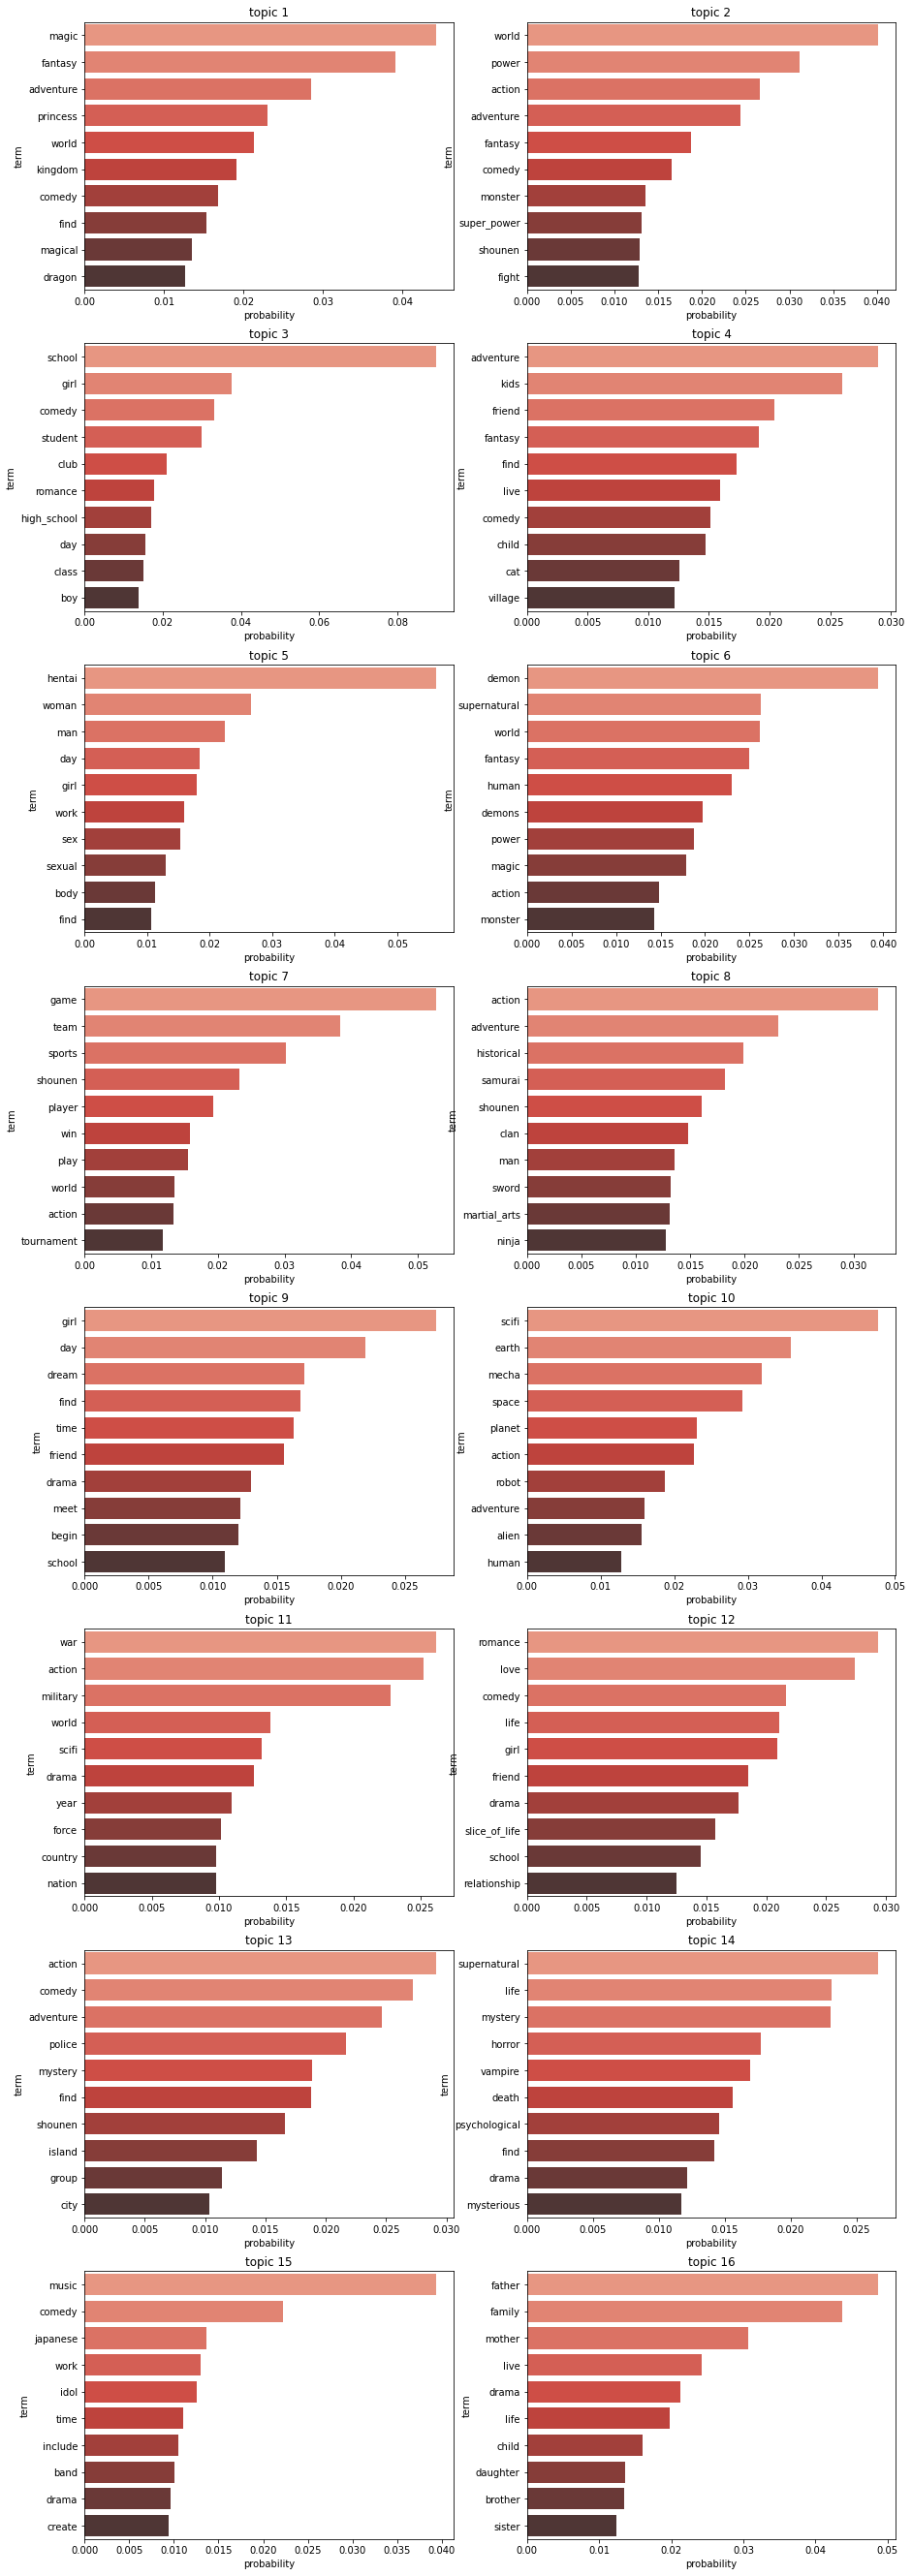

In [54]:
fiz=plt.figure(figsize=(15,60))

for i in range(optimal_model_index + start):
    df_plt=pd.DataFrame(optimal_model.show_topic(i), columns=['term','prob']).set_index('term')
#     df=df.sort_values('prob')
    
    plt.subplot(10,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df_plt.index, data=df_plt, palette='Reds_d')
    plt.xlabel('probability')
    

plt.show()

### Similarity metric imports

In [55]:
import numpy as np
from scipy.spatial import distance

### Similarity metric

In [56]:
def create_topic_matrix(model, corpus):
    doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in model[corpus]])
    
    return doc_topic_dist

In [57]:
doc_topic_dist = create_topic_matrix(optimal_model, corpus)

In [58]:
def get_js_distances(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sim=[distance.jensenshannon(data,query) for data in matrix]
    return sim

In [59]:
def get_title_from_index(index, df):
    """
    Returns a title from an index in a dataframe
    
    index: int
        The index of the title.
    df: pandas.Dataframe
        Dataframe the title lies within.
    """
    
    title = df[df.index == index]['Title'].values[0]
    return title

def get_index_from_title(title, df):
    """
    Returns a title's index in a dataframe
    
    title: string
        Title to find its index.
    df: pandas.Dataframe
        Dataframe the title lies within.
    """
    
    index = df[df['Title'] == title].index.values[0]
    return index

def recommend(matrix, title = None, synopsis = None, synopsis_genres = None, measure="similarity", k=10):
    """
    
    """
    
    if title is None and synopsis is None:
        return
    
    score_indexes = []
    title_indexes = []
    
    if title is not None:
        title_index = get_index_from_title(title, spacy_df)
        jensen_shannon_scores = get_js_distances(matrix[title_index], matrix)
        most_similar_indexes = np.array(jensen_shannon_scores).argsort()
        
        if measure == 'similarity':
            sorted_js_scores = np.array(sorted(jensen_shannon_scores, reverse=True))
            score_indexes = sorted_js_scores[1:k + 1]
            title_indexes = most_similar_indexes[1:k + 1]
        elif measure == 'distance':
            sorted_js_scores = np.array(sorted(jensen_shannon_scores, reverse=False))
            score_indexes = sorted_js_scores[:k]
            title_indexes = most_similar_indexes[::-1][:k]
        
    elif synopsis is not None:
        cleaned_synopsis = prepare_text(synopsis)
        
        if synopsis_genres is not None:
            cleaned_synopsis = cleaned_synopsis + ' ' + seperate_genres(synopsis_genres)
            
        cleaned_synopsis_split = cleaned_synopsis.split()
        synopsis_bow = dictionary.doc2bow(cleaned_synopsis_split)
        synopsis_distribution = np.array([tup[1] for tup in optimal_model[synopsis_bow]])
        jensen_shannon_scores = get_js_distances(synopsis_distribution, matrix)
        most_similar_indexes = np.array(jensen_shannon_scores).argsort()
        
        if measure == 'similarity':
            sorted_js_scores = np.array(sorted(jensen_shannon_scores, reverse=True))
            score_indexes = sorted_js_scores[1:k + 1]
            title_indexes = most_similar_indexes[1:k + 1]
        elif measure == 'distance':
            sorted_js_scores = np.array(sorted(jensen_shannon_scores, reverse=False))
            score_indexes = sorted_js_scores[:k]
            title_indexes = most_similar_indexes[::-1][:k]
    
    # (title name, jensen shannon score, topic distribution)
    titles_with_weights = [(get_title_from_index(title_idx, spacy_df), score_indexes[idx], matrix[title_idx]) for idx, title_idx in enumerate(title_indexes)]
    return titles_with_weights

In [65]:
# Predict through title
recommend(doc_topic_dist, title = 'Naruto', measure = 'similarity', k = 10)

[('Kuiba III: Zhanshen Jueqi',
  0.7853065875546963,
  array([0.09169564, 0.11871815, 0.0108857 , 0.10342482, 0.003891  ,
         0.13788023, 0.01837147, 0.42863265, 0.00511665, 0.02097876,
         0.00845564, 0.00500145, 0.00903279, 0.02462523, 0.00352362,
         0.00976622])),
 ('InuYasha Movie 4: Guren no Houraijima',
  0.7848582757179587,
  array([0.03105813, 0.31577641, 0.00850171, 0.09699694, 0.01115005,
         0.21718525, 0.00218129, 0.14414813, 0.02832967, 0.02855115,
         0.02282622, 0.00796172, 0.04761055, 0.02328785, 0.01086313,
         0.0035718 ])),
 ('Ragnarök The Animation',
  0.782971811503098,
  array([0.01758166, 0.00197876, 0.00940437, 0.1926585 , 0.00172026,
         0.33416221, 0.01500977, 0.38235398, 0.0068538 , 0.00238752,
         0.00144253, 0.00221121, 0.0016977 , 0.00170385, 0.01303698,
         0.01579692])),
 ('Kenyuu Densetsu Yaiba',
  0.7817549625876763,
  array([0.01382641, 0.10908864, 0.06839813, 0.15843202, 0.00283211,
         0.02476441, 0

In [61]:
# Predict through synopsis
recommend(doc_topic_dist, synopsis = 'It is the year 20XX. Earth was assaulted by monsters that would come to be known as "the Enemy of Humanity." In order to deal with this threat, special schools composed of teenagers with extraordinary abilities were formed. These people, who came to be known as "the Talented," had abilities that could defy the rules of reality. Among these people with supernatural powers was an outlier, an individual who was sent to one of these schools despite having no innate special abilities whatsoever. This is the story of our protagonist, who attempts to defeat the Enemies of Humanity through the use of intelligence and manipulation alone.', synopsis_genres='super_power,psychological,supernatural,thriller,shounen', measure = 'similarity', k = 5)

[('Toaru Majutsu no Index',
  0.7937440753723773,
  array([0.01299   , 0.39915685, 0.28719946, 0.00210485, 0.00172026,
         0.00126727, 0.0012348 , 0.0035425 , 0.00914962, 0.02075414,
         0.00144253, 0.00909869, 0.010881  , 0.23358239, 0.00385367,
         0.00202196])),
 ('Code:Breaker',
  0.7931971877777192,
  array([0.0200698 , 0.36391973, 0.17059989, 0.01026492, 0.00196371,
         0.00406735, 0.00403028, 0.00404384, 0.00258228, 0.0027254 ,
         0.00164667, 0.0156278 , 0.00980015, 0.36622665, 0.0096405 ,
         0.01279103])),
 ('Yuuki Yuuna wa Yuusha de Aru',
  0.7926739770692751,
  array([0.00610252, 0.53461065, 0.24817039, 0.00440067, 0.00172026,
         0.00815476, 0.00353063, 0.00124668, 0.02062876, 0.00238752,
         0.00603418, 0.00909869, 0.0016977 , 0.13027017, 0.00155784,
         0.02038857])),
 ('Arifureta Shokugyou de Sekai Saikyou',
  0.7923487540486829,
  array([0.00405825, 0.37658373, 0.15443094, 0.01937675, 0.00183395,
         0.04785435, 0.01844

### Save data

In [62]:
spacy_df.to_pickle('../anime_recs_synopsis/model_files/spacy_df.pkl')

In [63]:
np.save('../anime_recs_synopsis/model_files/doc_topic_dist.npy', doc_topic_dist)

In [67]:
dictionary.save('../anime_recs_synopsis/model_files/dictionary')

In [69]:
optimal_model.save('../anime_recs_synopsis/model_files/lda.model')